## Example 10.
### Sensitivity of hydraulic head at a point to <font color='blue'>heterogeneous hydraulic conductivity</font> under steady state flow conditions

## 0. Forward model
<br>
Governing equation:

$\begin{align}
\quad\quad K\ b\ \frac{d^2h}{dx^2}+R=0\cr
\cr\end{align}$

Boundary conditions:

$\begin{align}
\quad\quad -K\ b\ \frac{dh(x)}{dx}=0\ ,\quad\quad\;\;\, x=0=\Gamma_2\cr
\end{align}$

$\begin{align}
\quad\quad h(x)=h_{\Gamma_1}\ ,\quad\quad\quad\quad\quad x=L=\Gamma_1\cr
\cr\end{align}$

In [83]:
from IPython.display import HTML, display
def set_background(color):
    script = (
        "var cell = this.closest('.code_cell');"
        "var editor = cell.querySelector('.input_area');"
        "editor.style.background='{}';"
        "this.parentNode.removeChild(this)").format(color)
    display(HTML('<img src onerror="{}">'.format(script)))

In [84]:
from warnings import filterwarnings
filterwarnings("ignore", category=DeprecationWarning)

import numpy as np
R, b, L, BC1h, ocol = 1e-1/1000., 10., 10000., 0., 5000
X = np.arange(L)
K1, K2 = 1., 10.
K = np.hstack([K1*np.ones([1,round(2*L/3)]), K2*np.ones([1,round(L/3)])])

## 1. Direct sensitivity

$\begin{align}
\quad\quad\rm{Not\ available}
\cr\end{align}$

## 2. Perturbation sensitivity
$\begin{align}\cr
\frac{\partial h(x')}{\partial K}\approx\frac{h(x,K+\Delta K)-h(x,K)}{\Delta K}\;
\cr\cr\end{align}$

### 2a. Analytical
$\begin{align}
\quad\quad\rm{Not\ available}
\cr\end{align}$

### 2b. Semi-analytical

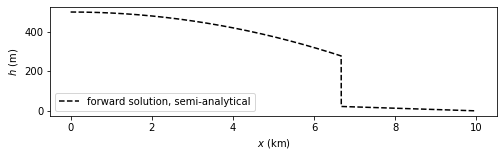

In [85]:
from os import getcwd, chdir
cwd = getcwd()
chdir(r'../../timml')
import timml
chdir(cwd)

M0 = timml.Model3D(kaq=K1, z=[0.,-b])
timml.inhomogeneity1d.StripInhom3D(M0, x1=2*L/3., x2=L, kaq=K2, z=[0,-b], topboundary='conf')
timml.ImpLineDoublet1D(M0, xld=0.)
timml.HeadLineSink1D(M0, xls=L, hls=0.)
timml.StripAreaSink(M0, 0., L, R)
M0.solve(silent=True)
H0 = M0.headalongline(X, 0.).flatten()

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.subplots(figsize=[8,2])
plt.plot(X/1000., H0, 'k--', mfc='none', label='forward solution, semi-analytical')
plt.xlabel('$x$ (km)')
plt.ylabel('$h$ (m)')
plt.legend(loc=3);

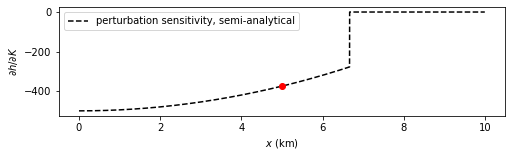

In [86]:
M1 = timml.Model3D(kaq=K1+K1*dpar, z=[0., -b])
timml.inhomogeneity1d.StripInhom3D(M1, x1=2*L/3., x2=L, kaq=K2, z=[0,-b], topboundary='conf')
timml.ImpLineDoublet1D(M1, xld=0.)
timml.HeadLineSink1D(M1, xls=L, hls=0.)
timml.StripAreaSink(M1, 0., L, R)
M1.solve(silent=True)
H1 = M1.headalongline(X, 0.).flatten()
dhdK = (H1-H0)/(K1*dpar)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.subplots(figsize=[8,2])
plt.plot(X/1000., dhdK, 'k--', mfc='none', label='perturbation sensitivity, semi-analytical')
plt.plot(ocol/1000., dhdK[ocol], 'ro')
plt.xlabel('$x$ (km)')
plt.ylabel(r'$\partial h / \partial K$')
plt.legend();

In [87]:
set_background('rgba(0, 200, 0, 0.2)')
print('%.6f'% dhdK[ocol])

-374.962504


### 2c. Numerical

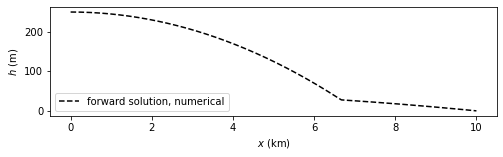

In [88]:
import flopy

nrow, ncol = 1, int(L)
M0 = flopy.modflow.Modflow(modelname='model', exe_name='../mf2005.exe')
flopy.modflow.ModflowDis(M0, nlay=1, nrow=nrow, ncol=ncol, nper=1, delr=1., delc=1., top=0., botm=-b, steady=True, 
                         perlen=1., nstp=1)
flopy.modflow.ModflowBas(M0, ibound=np.hstack([np.ones([nrow, ncol-1], dtype=int), -1*np.ones([1,1])]), 
                         strt=BC1h*np.ones([nrow, ncol], dtype=float))
flopy.modflow.ModflowLpf(M0, hk=K, vka=-999., ss=-999., sy=-999., ipakcb=53)
flopy.modflow.ModflowRch(M0, nrchop=1, rech=R, ipakcb=53)
flopy.modflow.ModflowPcg(M0, hclose=1e-6, rclose=1e-6)
flopy.modflow.ModflowOc(M0, stress_period_data={(0,0): ['save head', 'save budget']})
M0.write_input()
success, buff = M0.run_model(silent=True)
H0 = flopy.utils.binaryfile.HeadFile('model.hds').get_data()[0,0,:]

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.subplots(figsize=[8,2])
plt.plot(X/1000., H0, 'k--', mfc='none', label='forward solution, numerical')
plt.xlabel('$x$ (km)')
plt.ylabel('$h$ (m)')
plt.legend(loc=3);

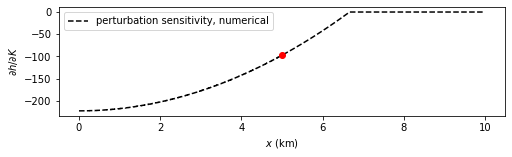

In [89]:
dpar = 1e-4
Kp = np.hstack([(K1+K1*dpar)*np.ones([1,round(2*L/3)]), K2*np.ones([1,round(L/3)])])
M1 = M0
flopy.modflow.ModflowLpf(M1, hk=Kp, vka=-999., ss=-999., sy=-999., ipakcb=53)
M1.write_input()
success, buff = M1.run_model(silent=True)
H1 = flopy.utils.binaryfile.HeadFile('model.hds').get_data()[0,0,:]
dhdK = (H1-H0)/(K1*dpar)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.subplots(figsize=[8,2])
plt.plot(X/1000., dhdK, 'k--', mfc='none', label='perturbation sensitivity, numerical')
plt.plot(ocol/1000., dhdK[ocol], 'ro')
plt.xlabel('$x$ (km)')
plt.ylabel(r'$\partial h / \partial K$')
plt.legend();

In [90]:
set_background('rgba(0, 200, 0, 0.2)')
#print('%.6f (%.6f)'% (dhdK[ocol], benchmark))
print('%.6f '% dhdK[ocol])

-97.274780 


## 3. Adjoint sensitivity

<br>
    
$\begin{align}
\quad\quad \frac{\partial h(x')}{\partial K}=\int\limits_X\psi^*_1(x)\ b\ \frac{d^2 h(x)}{d x^2}\; dx
\cr\end{align}$

Governing equation:

$\begin{align}
\quad\quad K\ b\ \frac{d\psi^*_1}{dx}+\frac{1}{2\ K\ b}\delta(x-x')=0\cr
\cr\end{align}$

Boundary conditions: 

$\begin{align}
\quad\quad -K\ b\ \frac{d\psi^*_1(x)}{dx}=0\ ,\quad\quad\; x=0=\Gamma_2\cr
\end{align}$

$\begin{align}
\quad\quad \psi^*_1(x)=0\ ,\ \quad\quad\quad\quad\quad x=L=\Gamma_1\cr
\cr\end{align}$

### 3a. Analytical

$\begin{align}
\quad\quad\rm{Not\ available}
\cr\end{align}$

### 3b. Semi-analytical

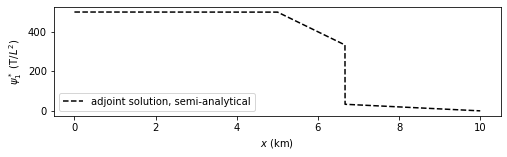

In [91]:
M0 = timml.Model3D(kaq=K1, z=[0., -b])
timml.inhomogeneity1d.StripInhom3D(M0, x1=2*L/3., x2=L, kaq=K2, z=[0,-b], topboundary='conf')
timml.ImpLineDoublet1D(M0, xld=0.)
timml.HeadLineSink1D(M0, xls=L, hls=0.)
timml.LineSink1D(M0, xls=float(ocol), sigls=-1.)
M0.solve(silent=True)
A = M0.headalongline(X, 0.).flatten()

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.subplots(figsize=[8,2])
plt.plot(X/1000., A, 'k--', mfc='none', label='adjoint solution, semi-analytical')
plt.xlabel('$x$ (km)')
plt.ylabel(r'$\psi^*_1$ (T/$L^2$)')
plt.legend(loc=3);

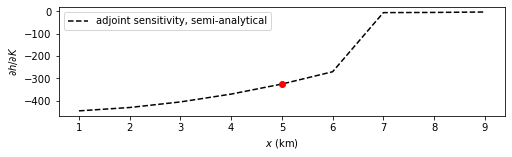

In [92]:
dhdK = np.empty(0)
for xp in X[::1000]:
    M0 = timml.Model3D(kaq=K1, z=[0., -b])
    timml.inhomogeneity1d.StripInhom3D(M0, x1=2*L/3., x2=L, kaq=K2, z=[0,-b], topboundary='conf')
    timml.ImpLineDoublet1D(M0, xld=0.)
    timml.HeadLineSink1D(M0, xls=L, hls=0.)
    timml.LineSink1D(M0, xls=xp, sigls=-1.)
    M0.solve(silent=True)
    A = M0.headalongline(X, 0.).flatten() 
    dhdK = np.append(dhdK, np.sum(A*b*-R/(K1*b)))

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.subplots(figsize=[8,2])
plt.plot(X[::1000][1:]/1000., dhdK[1:], 'k--', mfc='none', label='adjoint sensitivity, semi-analytical')
plt.plot(ocol/1000., dhdK[int(ocol/1000)], 'ro')
plt.xlabel('$x$ (km)')
plt.ylabel(r'$\partial h / \partial K$')
plt.legend(loc=2);

In [94]:
set_background('rgba(0, 200, 0, 0.2)')
print('%.6f '% (dhdK[int(np.where(X[::1000]==float(ocol))[0])]))

-325.020001 


### 3c. Numerical, continuous

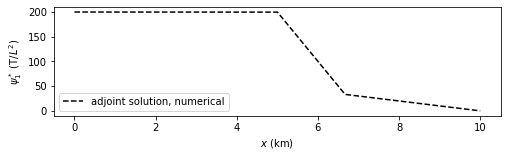

In [95]:
M0 = flopy.modflow.Modflow(modelname='model', exe_name='../mf2005.exe')
flopy.modflow.ModflowDis(M0, nlay=1, nrow=1, ncol=ncol, nper=1, delr=1., delc=1., top=0., botm=-b, steady=True, 
                         perlen=1., nstp=1)
flopy.modflow.ModflowBas(M0, ibound=np.hstack([np.ones([nrow, ncol-1], dtype=int), -1*np.ones([1,1])]), 
                         strt=np.zeros([nrow, ncol], dtype=float))
flopy.modflow.ModflowLpf(M0, hk=K, vka=-999., ss=-999., sy=-999., ipakcb=53)
flopy.modflow.ModflowWel(M0, stress_period_data={0: [0, 0, ocol, 1.]})
flopy.modflow.ModflowPcg(M0, hclose=1e-6, rclose=1e-6)
flopy.modflow.ModflowOc(M0, stress_period_data={(0,0): ['save head', 'save budget']})
M0.write_input()
success, buff = M0.run_model(silent=True)
A = flopy.utils.binaryfile.HeadFile('model.hds').get_data()[0,0,:]

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.subplots(figsize=[8,2])
plt.plot(X/1000., A, 'k--', mfc='none', label='adjoint solution, numerical')
plt.xlabel('$x$ (km)')
plt.ylabel(r'$\psi^*_1$ (T/$L^2$)')
plt.legend(loc=3);

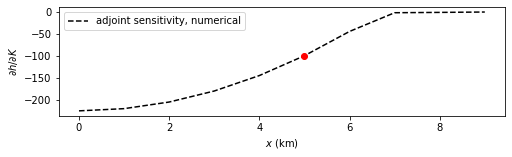

In [96]:
#dhdK = np.empty(0)
dhdK = []
for oc,xp in enumerate(X[::1000]):
    M1 = M0
    flopy.modflow.ModflowWel(M1, stress_period_data={0: [0, 0, oc*1000, 1.]})
    M1.write_input()
    success, buff = M1.run_model(silent=True)
    A = flopy.utils.binaryfile.HeadFile('model.hds').get_data()
    #dhdK = np.append(dhdK, np.sum(A[:round(2*L/3)]*b*-R/K*b))
    dhdK.append(-b*np.float(np.atleast_2d(np.gradient(np.ravel(H0)))@np.atleast_2d(np.gradient(np.ravel(A))).T))

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
f,s = plt.subplots(figsize=[8,2])
plt.plot(X[::1000]/1000., dhdK, 'k--', mfc='none', label='adjoint sensitivity, numerical')
plt.plot(ocol/1000., dhdK[int(ocol/1000)], 'ro')
plt.xlabel('$x$ (km)')
plt.ylabel(r'$\partial h / \partial K$')
plt.legend();

In [97]:
set_background('rgba(0, 200, 0, 0.2)')
#print('%.6f (%.6f)'% (dhdK[int(np.where(X[::1000]==float(ocol))[0])], benchmark))
print('%.6f '% (dhdK[int(np.where(X[::1000]==float(ocol))[0])]))

-99.976749 
